**1. Importing Libraries**

In [71]:
# main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn models and other functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from xgboost import XGBRegressor
# other libraries
import warnings
warnings.filterwarnings('ignore')
import time
from joblib import dump,load



**2. Importing and Reading data**

In [ ]:
!pip install opendatasets


In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/mirichoi0218/insurance'
od.download(dataset_url)
#{"username":"your_kaggle_name","key":"created_by_kaggle"}

**Dataset Description**

1. age: age of primary beneficiary

2. sex: Gender either a **female** or **male**

3. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

4. children: Number of children covered by health insurance / Number of dependents

5. smoker: Smoking

6. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

7. charges: Individual medical costs billed by health insurance

                     **Categorical columns**
                     1. sex
                     2. Smoker
                     3. Region

                    ** Numerical columns**
                    1. Age
                    2. bmi
                    3. charges
                    4. children




In [5]:
# read the csv file using pandas dataframe
data_path ='/content/insurance/insurance.csv'
dataframe = pd.read_csv(data_path)
# read first five rows
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# shape of the dataframe
dataframe.shape 
#(1338, 7) 
# 1338 ---> Number of rows in a dataframe
# 7    ---> Number of columns in a dataframe

(1338, 7)

In [7]:
#information about the dataframe
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
# statistical information about each numerical columns
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [9]:
# data types of each column
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [10]:
# names of a columns
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

#**3. Data Analysis**

In [11]:
# checking for null values
dataframe.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [12]:
# correlatiom map
correlation = dataframe.corr()
correlation

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


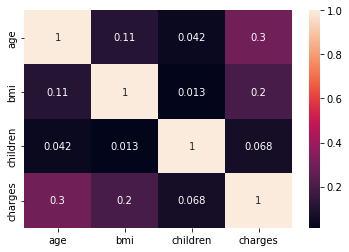

In [13]:
#heatmap
sns.heatmap(correlation,annot=True)

A strong correlation is observed with smoking patients

**3.1 Distribution of numerical features**

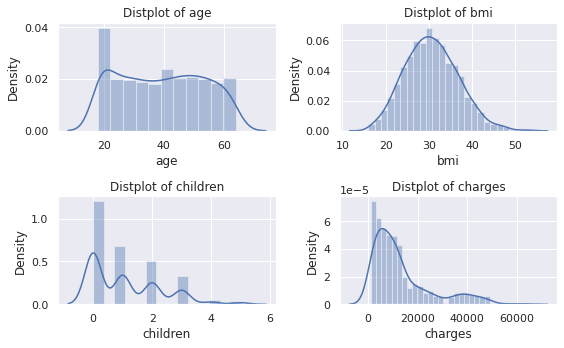

In [14]:
numerical_column = list(dataframe.select_dtypes(['int64','float64']).columns)
categorical_column = list(dataframe.select_dtypes('object').columns)

def plot(df,plot_kind,column_list):
  figure = plt.figure(figsize=(8,5))
  sns.set()
  plot_kind = plot_kind.lower()
  plot_function = {'distplot':sns.distplot,
                   'countplot':sns.countplot}
  if plot_kind == 'distplot':
    for index,column in enumerate(column_list):
      row = len(column_list)/2
      axis = figure.add_subplot(row,2,index+1)
      plot_function[plot_kind](df[column],ax = axis).set_title(f'Distplot of {column}')
    plt.tight_layout()
    plt.show()

  elif plot_kind =='countplot':
    for index,column in enumerate(column_list):
      axis = figure.add_subplot(1,3,index+1)
      plot_function[plot_kind](df[column],ax = axis).set_title(f'countplot of {column}')
      plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot(dataframe,'distplot',numerical_column)



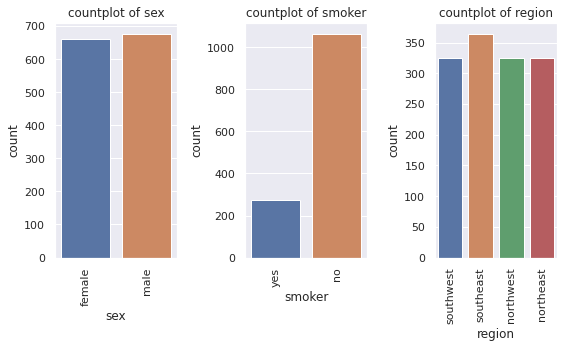

In [15]:
plot(dataframe,'countplot',categorical_column)

In [16]:
numerical_column

['age', 'bmi', 'children', 'charges']

In [17]:
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

**Dsitribution of charges for smokers**

Text(0.5, 1.0, 'Distribution for smokers')

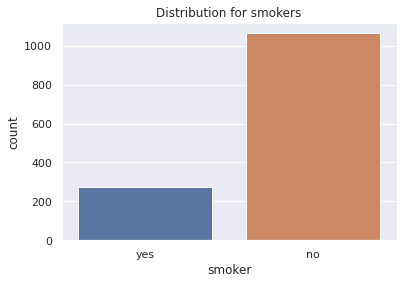

In [18]:
smokers = dataframe[dataframe['smoker']=='yes']
non_smokers = dataframe[dataframe['smoker']=='no']
dataframe['smoker'].value_counts()
sns.countplot(dataframe['smoker']).set_title('Distribution for smokers')

**Majority of people do not smoke**

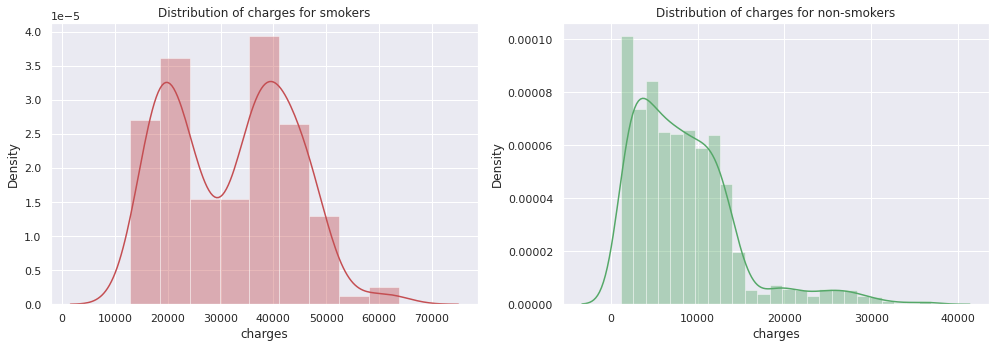

In [19]:
fig = plt.figure(figsize=(14,5))
axis = fig.add_subplot(1,2,1)
axis2 = fig.add_subplot(1,2,2)
sns.distplot(dataframe[dataframe.smoker=='yes']['charges'],ax=axis,color='r').set_title('Distribution of charges for smokers')
plt.tight_layout()
sns.distplot(dataframe[dataframe.smoker=='no']['charges'],ax=axis2,color='g').set_title('Distribution of charges for non-smokers')
plt.tight_layout()

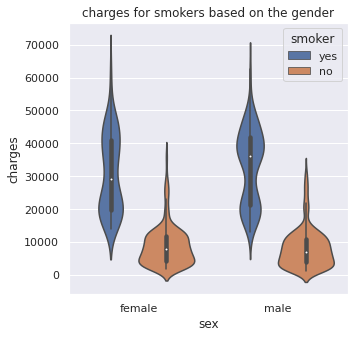

In [20]:
plt.figure(figsize=(5,5))
sns.violinplot(data=dataframe,x='sex',y='charges',hue='smoker').set_title('charges for smokers based on the gender')
plt.show()

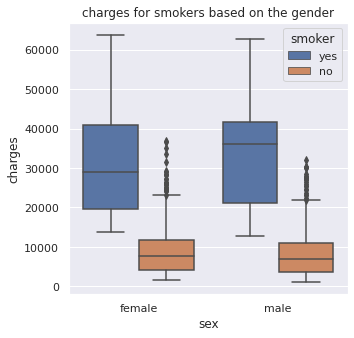

In [21]:
plt.figure(figsize=(5,5))
sns.boxplot(data=dataframe,x='sex',y='charges',hue='smoker').set_title('charges for smokers based on the gender')
plt.show()

How age affect the charges

Text(0.5, 1.0, 'Age Distribution')

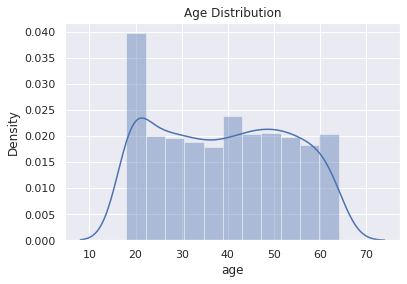

In [22]:
#age distribution
sns.distplot(dataframe['age']).set_title('Age Distribution')

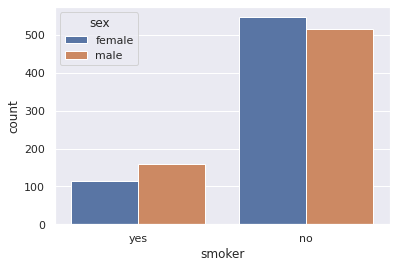

In [23]:

sns.countplot(data=dataframe,x='smoker',hue='sex')

**Men smoke more than women**

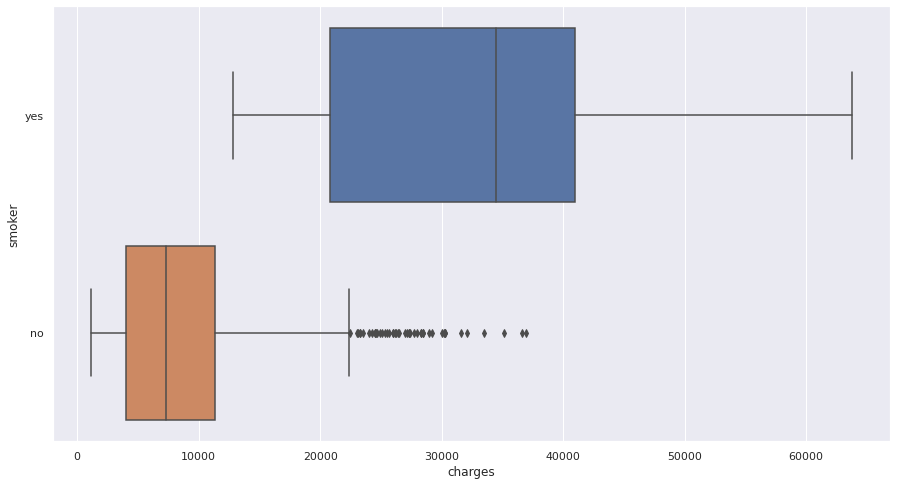

In [24]:
#Does smoking affect the cost of treatment at this age?
plt.figure(figsize=(15,8))
sns.boxplot(x='charges',data=dataframe,y='smoker')

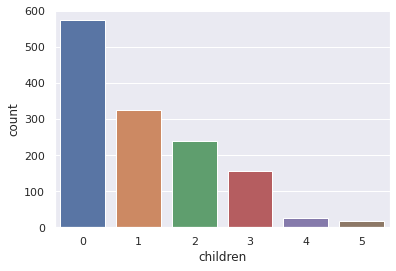

In [25]:
# distribution of childrens
sns.countplot(dataframe['children'])

**Most people they do not have childre**

#**4. Data Preprocessing**

**4.1 Label encoding**

In [26]:
# label encoding using sklearn LabelEncoder
def encode(df, method = 'label'):
    df = df.copy()
    get_categorical_column = list(df.select_dtypes('object').columns)
    if method == 'label':
        for column in get_categorical_column:
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
    elif method == 'one_hot':
        df = pd.get_dummies(df, columns=get_categorical_column)
    return df

dataframe= encode(dataframe,'label')


#**5. Modeling**

In [77]:
#seperate features and target column and turn it int a numpy array
features = dataframe.drop('charges',axis=1).values
target = dataframe['charges'].values

In [28]:
# split dataset into train and test part. 
train_data,test_data,train_labels,test_labels = train_test_split(features,target,test_size=0.2,random_state=0)

In [29]:
# linear regression model, base model
l_model = LinearRegression()
l_model.fit(train_data,train_labels)


LinearRegression()

In [30]:
# prediction on training data and test data
train_prediction = l_model.predict(train_data)
test_prediction = l_model.predict(test_data)


In [31]:
# r2_Score
train_r2Score = r2_score(train_prediction,train_labels)
test_r2Score = r2_score(test_prediction,test_labels)
print('Accuracy for train data: ',train_r2Score)
print('Accuracy for test data: ',test_r2Score)

Accuracy for train data:  0.6428359937844945
Accuracy for test data:  0.7245405921827406


**5.1 Model Selection**

In [65]:
models = [LinearRegression(),XGBRegressor(verbose=0,silent=True),RandomForestRegressor(n_estimators=100,criterion='mse',random_state=1,n_jobs=-1)]
model_results=[]
prediction_results = []
def best_model(model_list):
  for model in model_list:
    start_time = time.time()
    model.fit(train_data,train_labels)
    model_prediction = model.predict(test_data)
    model_r2score = r2_score(model_prediction,test_labels)
    formatted_r2score = round(model_r2score*100,2)
    end_time = time.time()
    execution_time = round(end_time-start_time,2)
    prediction_results.append({'model_name':str(model),'model prediction':model_prediction})
    model_results.append({'model_name':str(model),'modelr2score':formatted_r2score,'execution time':execution_time})
  df = pd.DataFrame(model_results)
  return df,prediction_results

df=best_model(models)[0]
prediction = best_model(models)[1]
df

,model_name,modelr2score,execution time
0,LinearRegression(),72.45,0.01
1,"XGBRegressor(silent=True, verbose=0)",88.49,0.08
2,"RandomForestRegressor(criterion='mse', n_jobs=...",86.70,0.64


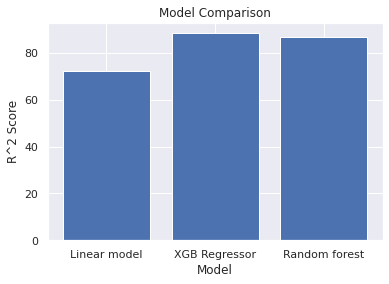

In [45]:
model_names = ['Linear model','XGB Regressor','Random forest']
plt.bar(model_names, df['modelr2score'])
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('Model Comparison')
#plt.xticks(rotation=90)
plt.show()


In [67]:
results = df
#save the model
results.to_csv('model_results.csv',index=False)

In [69]:
results.to_csv('model_results.csv', index=False)
dump(results,'model_results.joblib')


['model_results.joblib']

#**6. Hyperparameter Tuning**

In [88]:
models = [LinearRegression(),XGBRegressor(),RandomForestRegressor()]

model_parameters = [
    {'fit_intercept':[True,False],'n_jobs': [1, -1],'normalize': [True, False],'positive': [True, False]},
    {'verbose':[0,1],'silent':[True,False]},
    {'n_estimators':[50,100,200],'criterion':['mse','mae'],'random_state':[1,42]}
]
grid_searc_results = []
def model_tuning(models,parameters):
  for index,model in enumerate(models):
    gscv = GridSearchCV(model,parameters[index],n_jobs=-1,cv=5)
    gscv.fit(features,target)
    grid_searc_results.append({
        'model_name':str(model),
        'best score':gscv.best_score_,
        'best parameter':gscv.best_params_
    })
  return pd.DataFrame(grid_searc_results)

gscv_df = model_tuning(models,model_parameters)
gscv_df

,model_name,best score,best parameter
0,LinearRegression(),0.747256,"{'fit_intercept': True, 'n_jobs': 1, 'normaliz..."
1,XGBRegressor(),0.856720,"{'silent': True, 'verbose': 0}"
2,RandomForestRegressor(),0.836174,"{'criterion': 'mse', 'n_estimators': 200, 'ran..."
